# ELE 435-535 Computation HW2: PCA

### Name: Ze Chen

### Import required Python packages

In [1]:
# Import additional packages if needed
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as io
from sklearn import svm

plt.rcParams['text.usetex'] = True
%matplotlib inline

### YALE B Dataset

You will use the YALE B face dataset to explore PCA. The Yale B dataset contains frontal face images (size 192 x 168) of 38 subjects, with around 64 images per subject (not all subjects have the same number of images). The total number of images is 2,414. The images have been column-wise vectorized into 192 x 168 = 32,256 column vectors and stored as the columns of a matrix X. The corresponding 2,414 labels, ranging from 1 to 39 (no 14), are provided in a row vector Y. For background and additional reading, see http://research.microsoft.com/pubs/132810/PAMI-Face.pdf.

### Display Some Images

In [2]:
# This cell is given. You do not need to modify it.

# Functions to represent the image as a matrix or a column vector
def packcw(A):
    return (A.T).reshape(-1,1)

def unpackcw(x,nr):
    return x.reshape(-1,nr).T

0) Load the YALEBXF.mat face data and display the first image of 38 subjects on a 5 x 8 tile.  
(This part is done as an example) 

Train Data: 32256 x 1520
Test Data: 32256 x 894
(1520,)
(32256, 2414)
(1, 2414)


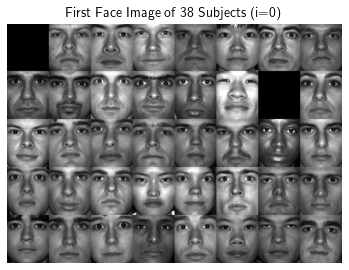

In [3]:
# This cell is given. You do not need to modify it.
# You can reuse this code for other questions below but 
# reference its source: ECE_4/535_codebase_ramadge.

# Load the YALE database
# Train data (X_train): 32256 x 1520 (40 examples for 38 subjects)
# Train label (Y_train): 1520 x 1 (38 subjects (0 ~ 37))
# Test data (X_test): 32256 x 894 (Test examples vary for different subjects)
# Test label (Y_test): 894 x 1 (38 subjects (0 ~ 37))

YALE = io.loadmat('YALEBXF.mat') 
X = YALE['X']/255.0
Y = YALE['Y']
nr, nc = 192, 168 # height = 192, width = 168
dim = nr * nc     # dimension = 32256
nex = X.shape[1]  # Total number of examples = 2414

nFc = 38          # Total number of faces
nImg = np.zeros(nFc+2) # Numper of examples for each person
for i in range(nFc+2):
    nImg[i] = (Y==i).sum()

ntr = 40
X_train = np.zeros((dim,nFc*ntr))
Y_train = np.zeros(nFc*ntr)
X_test = np.zeros((dim,nex-nFc*ntr))
Y_test = np.zeros(nex-nFc*ntr)

nImg_eff = nImg[np.where(nImg>0)]
nImg_test = nImg_eff - ntr
for i in range(nFc):
    X_train[:,i*ntr:(i+1)*ntr] = X[:,int(np.sum(nImg_eff[:i])):int(np.sum(nImg_eff[:i]))+40]
    Y_train[i*ntr:(i+1)*ntr] = i
    X_test[:,int(np.sum(nImg_test[:i])):int(np.sum(nImg_test[:i+1]))] = X[:,int(np.sum(nImg_eff[:i]))+40:int(np.sum(nImg_eff[:i+1]))]
    Y_test[int(np.sum(nImg_test[:i])):int(np.sum(nImg_test[:i+1]))] = i
    
print ('Train Data: %d x %d' %(X_train.shape[0],X_train.shape[1]))
print ('Test Data: %d x %d' %(X_test.shape[0],X_test.shape[1]))

print(Y_train.shape)
print(X.shape)
print(Y.shape)

def unpackcw(x,nr):
    return x.reshape(-1,nr).T


# Faceboard of 38 faces
faceIdx = 0 # index of face to display for each subject
Bh, Bw = 5, 8
FB = np.zeros((Bh*nr, Bw*nc))
for i in range(nFc+2):
    if nImg[i]>0:
        loc = np.where(Y==i)[1]
        x = X[:,loc[faceIdx]]
        A = unpackcw(x,nr)
        row, col = divmod(i,Bw)
        rpt, cpt = row*nr, col*nc
        FB[rpt:rpt+nr, cpt:cpt+nc] = A
plt.figure(figsize = (6,6))
plt.imshow(FB, cmap='gray')
plt.axis('off')
plt.title("First Face Image of 38 Subjects (i=%i)" %faceIdx, fontsize=14)
plt.show()

### Part I: PCA

1a）Compute the SVD of the centered training data (You can use the **np.linalg.svd( )** function).   
1b) Plot the PCA captured **variance** of the principal components from $1$ to $j$ (normalized by the total variance) versus index $j$ . The y axis should go from 0 to 1 with tick marks in increments of 0.05, and the let the x axis go from 1 to 256 with tick marks at 8, 16, 32, ..., 256.

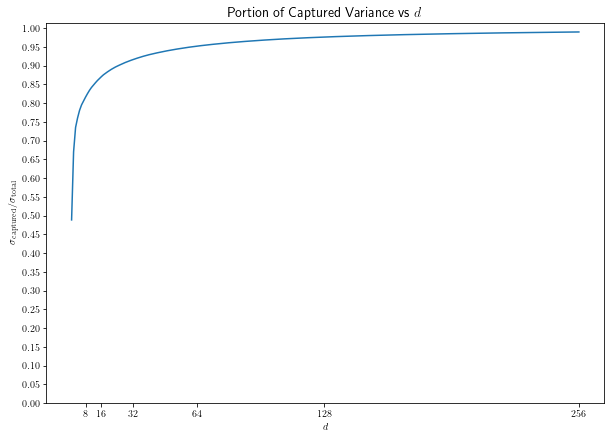

In [4]:
# Principal Components Analysis

X_train_mean = X_train.mean(axis=1).reshape(-1, 1)
X_train_centered = X_train - X_train_mean
u, s, vh = np.linalg.svd(X_train_centered, full_matrices=False)

variance_total = (s ** 2).sum()
variance_cumsum = np.pad((s ** 2).cumsum(), (1, 0))
variance_cumsum_normalized = variance_cumsum / variance_total
dimensions = np.arange(1, 257)
dimensions_pow_2 = 2 ** np.arange(3, 9)

fig = plt.figure(figsize=(10, 7))
plt.plot(dimensions, variance_cumsum_normalized[dimensions])
plt.xticks(dimensions_pow_2)
plt.yticks(np.arange(0, 1.05, 0.05))
plt.xlabel('$d$')
plt.ylabel(r'$\sigma_{\mathrm{captured}}/\sigma_{\mathrm{total}}$')
plt.title(f"Portion of Captured Variance vs $d$", fontsize=14)
plt.show()

1c) Use you plot from part 1b) to answer the following questions:   
[i] To the nearest 5%, what fraction of total variance is captured by the first principal component? ANS: 50%   
[ii] To the nearest power of 2, how many PC's are required to capture 95% of the total variance? ANS: 64    

2) Project the full data $X$ onto the first $d$ principal components for $d = 8,16,32,64,128,256$. Display the approximate faces for the same images from part 1) in a 5 x 8 tile. Remember to add back the mean before displaying the image.

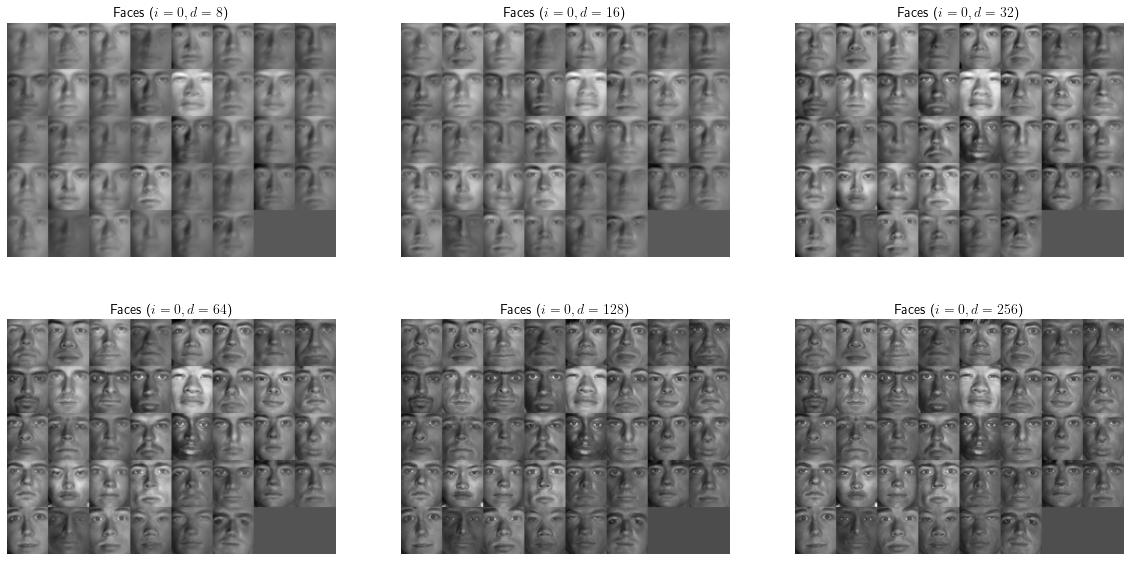

In [5]:
# Project the data onto the selected principal components

fig = plt.figure(figsize=(20, 10))

for (i, d) in enumerate(dimensions_pow_2):
    X_train_centered_projected = u[:, :d].dot(np.diag(s[:d])).dot(vh[:d, :])
    X_train_projected = X_train_centered_projected + X_train_centered_projected
    faces_projected = X_train_projected.T.reshape((-1, nc, nr)).transpose(0, 2, 1)

    rows = 5
    columns = 8
    face_idx = 0
    face_locations = [np.where(Y_train == i)[0][face_idx] for i in np.unique(Y_train)]
    faces_selected = faces_projected[face_locations]
    faces_reshaped = np.pad(faces_selected, ((0, rows * columns - faces_selected.shape[0]), (0, 0), (0, 0))).reshape((rows, columns, nr, nc))
    faces_gallery = faces_reshaped.transpose(0, 2, 1, 3).reshape(rows * nr, columns * nc)

    ax = fig.add_subplot(2, 3, i + 1)
    ax.imshow(faces_gallery, cmap='gray')
    ax.axis('off')
    plt.title(f"Faces ($i={face_idx}, d={d}$)", fontsize=14)
    
plt.show()

### Part II: SVM Classification

3） To test the effectiveness of PCA dimensionality reduction train a binary linear support vector machine (SVM) to classify **subject 0** versus **subject 1**, using PCA  projected training data. 

You do not need to know (yet) how the SVM works. We will cover that later. What is important for now is that it is a binary classifer with one hyperparameter $C>0$.
The first thing we need to do is select $C$. To do that project the centered training data and testing data onto the first 128 principal components of the centered training data. Then use this data to plot training accuracy vs $C$.


**Note:** Output data matrix should be 128 x N for both the training data and the testing data (in the reduced dimension).

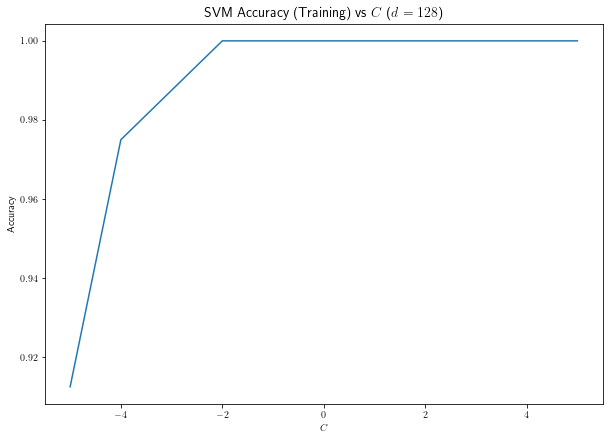

In [6]:
# Project the centered training data and testing data onto 
# the first 128 principal components of the centered training data.

d = 128

# projection of X_train

X_train_centered_projected_reduced = np.diag(s[:d]).dot(vh[:d, :])

# projection of X_test

X_test_mean = X_test.mean(axis=1).reshape(-1, 1)
X_test_centered = X_test - X_test_mean
X_test_centered_projected_reduced = u[:, :d].T.dot(X_test_centered)

# Form the training data using subjects 0, 1

train_binary_idx = np.where((Y_train == 0) | (Y_train == 1))[0]
X_train_centered_projected_reduced_binary = X_train_centered_projected_reduced[:, train_binary_idx]
Y_train_binary = Y_train[train_binary_idx]

test_binary_idx = np.where((Y_test == 0) | (Y_test == 1))[0]
X_test_centered_projected_reduced_binary = X_test_centered_projected_reduced[:, test_binary_idx]
Y_test_binary = Y_test[test_binary_idx]

# THIS PORTION OF CODE IS GIVEN TO YOU ----- uncomment to use

binary_train = X_train_centered_projected_reduced_binary
binary_train_label = Y_train_binary

C_list = np.arange(-5,6)
accuracy_list = []
for C in C_list:
    svm_binary = svm.SVC(kernel='linear', C=10.0**C)
    svm_binary.fit(binary_train.T, binary_train_label)
    
    binary_train_pred = svm_binary.predict(binary_train.T)
    
    accuracy = np.sum(binary_train_pred == binary_train_label) / float(len(binary_train_pred))
    accuracy_list.append(accuracy)
    
# -----

# Now plot the training accuracy vs C    

fig = plt.figure(figsize=(10, 7))
plt.plot(C_list, accuracy_list)
plt.xlabel('$C$')
plt.ylabel(r'Accuracy')
plt.title(f"SVM Accuracy (Training) vs $C$ ($d={d}$)", fontsize=14)
plt.show()

4）Based on the graph you obtain above select a reasonable value for $C$.
(e.g. something like $C = 10^{-2}$). 

Now repeat 4) for projected training data onto $d$ principal components where $d = 8,16,32,64,128,256,512$. This time plot both the training and testing accuracy vs. $d$. Use similar ticks marks for the x and y axies as in part 4).

What do you observe? How small a dimension can you select for the projection and a still obtain > 95% training and test accuracy **ANS:** $d=64$ for $C = 10^{-2}$ 

**Note:** In practice, we pick $d$ by measuring performance on a validation dataset. In addition, for each $d$ we would normally do a larger sweep of the hyperparameter $C$.

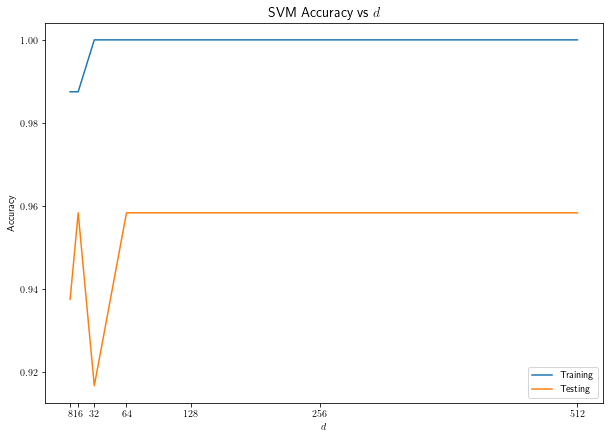

In [7]:
train_binary_idx = np.where((Y_train == 0) | (Y_train == 1))[0]
Y_train_binary = Y_train[train_binary_idx]
test_binary_idx = np.where((Y_test == 0) | (Y_test == 1))[0]
Y_test_binary = Y_test[test_binary_idx]

dimensions_pow_2 = 2 ** np.arange(3, 10)
fig = plt.figure(figsize=(10, 7))

accuracy_list_train = []
accuracy_list_test = []

for (i, d) in enumerate(dimensions_pow_2):
    X_train_centered_projected_reduced = np.diag(s[:d]).dot(vh[:d, :])
    X_test_centered_projected_reduced = u[:, :d].T.dot(X_test_centered)

    # Form the training data using subjects 0, 1
    
    X_train_centered_projected_reduced_binary = X_train_centered_projected_reduced[:, train_binary_idx]
    X_test_centered_projected_reduced_binary = X_test_centered_projected_reduced[:, test_binary_idx]
    
    binary_train = X_train_centered_projected_reduced_binary
    binary_train_label = Y_train_binary
    binary_test = X_test_centered_projected_reduced_binary
    binary_test_label = Y_test_binary

    
    C = -2
    svm_binary = svm.SVC(kernel='linear', C=10.0**C)
    svm_binary.fit(binary_train.T, binary_train_label)

    binary_train_pred = svm_binary.predict(binary_train.T)

    accuracy_train = np.sum(binary_train_pred == binary_train_label) / float(len(binary_train_pred))
    accuracy_list_train.append(accuracy_train)

    binary_test_pred = svm_binary.predict(binary_test.T)

    accuracy_test = np.sum(binary_test_pred == binary_test_label) / float(len(binary_test_pred))
    accuracy_list_test.append(accuracy_test)

    # -----  

ax = fig.add_subplot(1, 1, 1)
ax.plot(dimensions_pow_2, accuracy_list_train, label='Training')
ax.plot(dimensions_pow_2, accuracy_list_test, label='Testing')
ax.legend()
plt.xticks(dimensions_pow_2)
plt.xlabel('$d$')
plt.ylabel(r'Accuracy')
plt.title(f"SVM Accuracy vs $d$", fontsize=14)
plt.show()